In [ ]:
!pip install transformers datasets scikit-learn seaborn

import os, random, time
from pathlib import Path
import numpy as np, pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from torch.optim import AdamW
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
warnings.filterwarnings("ignore")

device = "cuda" if torch.cuda.is_available() else "cpu"
device


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 42.1 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 19.0.1
    Uninstalling pyarrow-19.0.1:
      Successfully uninstalled pyarrow-19.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
pylibcudf-cu12 25.2.2 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.
cudf-cu12 25.2.2 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
cudf-polars-cu12 25.6.0 requires pylibcudf-cu12==25.6.*, but you have pylibcudf-cu12 25.2.2 which is incompatible.


'cuda'

In [ ]:
import glob
input_root = '/kaggle/input'
csvs = []
for root, dirs, files in os.walk(input_root):
    for f in files:
        if f.lower().endswith('.csv'):
            csvs.append(os.path.join(root, f))
if len(csvs)==0:
    raise FileNotFoundError('No CSV found in /kaggle/input. Upload your dataset.')
csv_path = csvs[0]
print('Using CSV:', csv_path)
raw_df = pd.read_csv(csv_path)
print('Raw shape:', raw_df.shape)
raw_df.head()


Using CSV: /kaggle/input/liar-twitter-dataset/Liar_Dataset.csv
Raw shape: (12787, 14)


,[ID].json,label,statement,subject(s),speaker,speaker's job title,state info,party affiliation,barely true counts,false counts,half true counts,mostly true counts,pants on fire counts,venue
0,11972.json,TRUE,Building a wall on the U.S.-Mexico border will...,immigration,rick-perry,Governor,Texas,republican,30,30,42,23,18,Radio interview
1,11685.json,FALSE,Wisconsin is on pace to double the number of l...,jobs,katrina-shankland,State representative,Wisconsin,democrat,2,1,0,0,0,a news conference
2,11096.json,FALSE,Says John McCain has done nothing to help the ...,"military,veterans,voting-record",donald-trump,President-Elect,New York,republican,63,114,51,37,61,comments on ABC's This Week.
3,5209.json,half-true,Suzanne Bonamici supports a plan that will cut...,"medicare,message-machine-2012,campaign-adverti...",rob-cornilles,consultant,Oregon,republican,1,1,3,1,1,a radio show
4,9524.json,pants-fire,When asked by a reporter whether hes at the ce...,"campaign-finance,legal-issues,campaign-adverti...",state-democratic-party-wisconsin,NaN,Wisconsin,democrat,5,7,2,2,7,a web video


In [ ]:
label_map = {
    'pants-fire': 0, 'pants on fire': 0, 'pants on fire.': 0,
    'false': 1,
    'barely-true': 2, 'barely true': 2,
    'half-true': 3, 'half true': 3,
    'mostly-true': 4, 'mostly true': 4,
    'true': 5
}
raw_df['label'] = raw_df['label'].astype(str).str.lower().str.strip()
raw_df['label_mapped'] = raw_df['label'].map(label_map)
if raw_df['label_mapped'].isna().any():
    print('Unmapped labels:', raw_df[raw_df['label_mapped'].isna()]['label'].unique())
DF = raw_df[['statement','label_mapped']].dropna().rename(columns={'label_mapped':'label'}).reset_index(drop=True)
DF['label'] = DF['label'].astype(int)
print('Final DF shape:', DF.shape)
DF['label'].value_counts()

Final DF shape: (12787, 2)


label
3    2627
1    2504
4    2454
2    2102
5    2053
0    1047
Name: count, dtype: int64

In [ ]:
MODEL_NAME = "bert-base-uncased"
MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 10
LR = 2e-5
N_SPLITS = 5
SEED = 42

torch.manual_seed(SEED)
np.random.seed(SEED)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)



tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
class LIARDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )
        return {
            "ids": encoding["input_ids"].squeeze(),
            "mask": encoding["attention_mask"].squeeze(),
            "label": torch.tensor(self.labels[idx], dtype=torch.long)
        }


In [ ]:
class BertBiLSTMAttn(nn.Module):
    def __init__(self, model_name, lstm_hidden=128, num_classes=6, dropout=0.3):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)

        self.lstm = nn.LSTM(
            input_size=768,
            hidden_size=lstm_hidden,
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )

        self.attn = nn.Linear(lstm_hidden * 2, 1)
        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(lstm_hidden * 2, num_classes)

    def forward(self, ids, mask):
        bert_out = self.bert(ids, attention_mask=mask)
        seq_output = bert_out.last_hidden_state

        lstm_out, _ = self.lstm(seq_output)

        attn_weights = torch.softmax(self.attn(lstm_out), dim=1)
        context = torch.sum(attn_weights * lstm_out, dim=1)

        context = self.dropout(context)
        return self.out(context)


In [ ]:
def train_epoch(model, loader, optimizer, scheduler):
    model.train()
    total_loss, total_acc = 0, 0

    for batch in loader:
        ids = batch['ids'].to(device)
        mask = batch['mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(ids, mask)
        loss = nn.CrossEntropyLoss()(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        total_acc += (outputs.argmax(1) == labels).sum().item()

    return total_loss / len(loader), total_acc / len(loader.dataset)


def eval_model(model, loader):
    model.eval()
    preds, targets = [], []
    correct = 0

    with torch.no_grad():
        for batch in loader:
            ids = batch['ids'].to(device)
            mask = batch['mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(ids, mask)
            preds.extend(outputs.argmax(1).cpu().numpy())
            targets.extend(labels.cpu().numpy())

            correct += (outputs.argmax(1) == labels).sum().item()

    return correct / len(loader.dataset), np.array(targets), np.array(preds)


In [ ]:
all_train_acc = []
all_val_acc = []
all_train_loss = []
all_val_loss = []


----- FOLD 1 -----


2025-12-09 08:39:03.815031: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765269543.992262      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765269544.048358      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]


Epoch 1/10
Train Loss 1.7393 | Train Acc 0.2274
Val Acc   0.2490

Classification Report:
              precision    recall  f1-score   support

  pants-fire       0.00      0.00      0.00       210
       false       0.25      0.31      0.28       501
 barely-true       0.23      0.05      0.08       420
   half-true       0.24      0.27      0.25       525
 mostly-true       0.25      0.65      0.36       491
        true       0.50      0.00      0.00       411

    accuracy                           0.25      2558
   macro avg       0.25      0.21      0.16      2558
weighted avg       0.27      0.25      0.19      2558



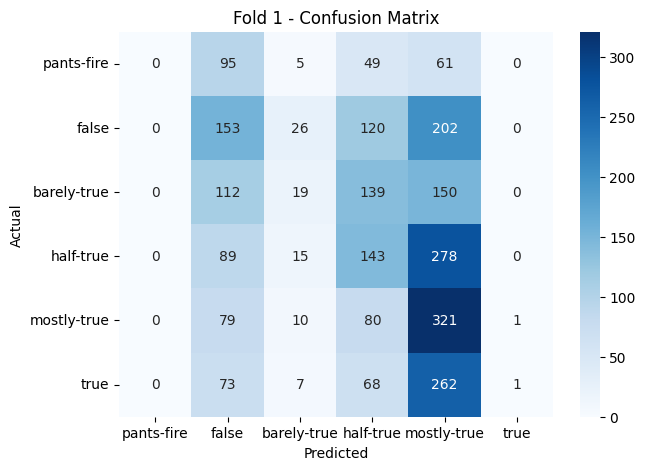


Epoch 2/10
Train Loss 1.6569 | Train Acc 0.2812
Val Acc   0.2596

Classification Report:
              precision    recall  f1-score   support

  pants-fire       0.57      0.08      0.13       210
       false       0.26      0.30      0.28       501
 barely-true       0.24      0.05      0.09       420
   half-true       0.25      0.49      0.33       525
 mostly-true       0.26      0.32      0.29       491
        true       0.25      0.15      0.19       411

    accuracy                           0.26      2558
   macro avg       0.31      0.23      0.22      2558
weighted avg       0.28      0.26      0.23      2558



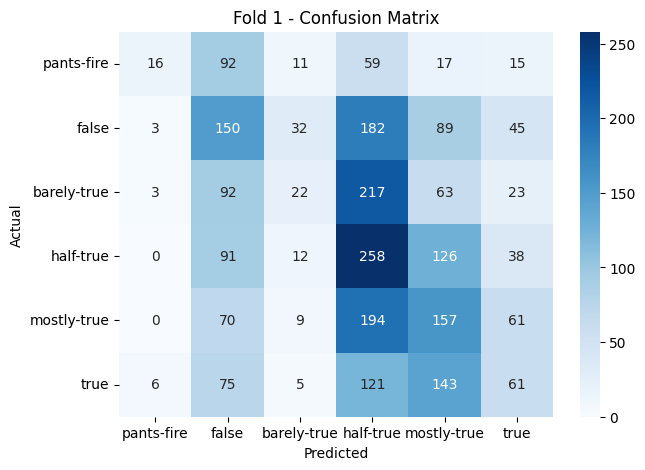


Epoch 3/10
Train Loss 1.4695 | Train Acc 0.3947
Val Acc   0.2674

Classification Report:
              precision    recall  f1-score   support

  pants-fire       0.35      0.21      0.27       210
       false       0.28      0.23      0.26       501
 barely-true       0.23      0.15      0.18       420
   half-true       0.26      0.46      0.33       525
 mostly-true       0.26      0.20      0.23       491
        true       0.28      0.28      0.28       411

    accuracy                           0.27      2558
   macro avg       0.28      0.26      0.26      2558
weighted avg       0.27      0.27      0.26      2558



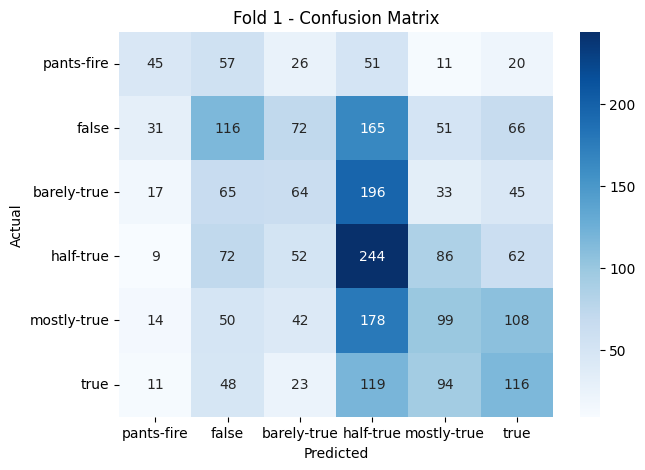


Epoch 4/10
Train Loss 1.1118 | Train Acc 0.5778
Val Acc   0.2740

Classification Report:
              precision    recall  f1-score   support

  pants-fire       0.32      0.27      0.29       210
       false       0.29      0.31      0.30       501
 barely-true       0.25      0.20      0.22       420
   half-true       0.28      0.29      0.28       525
 mostly-true       0.25      0.23      0.24       491
        true       0.27      0.35      0.31       411

    accuracy                           0.27      2558
   macro avg       0.28      0.27      0.27      2558
weighted avg       0.27      0.27      0.27      2558



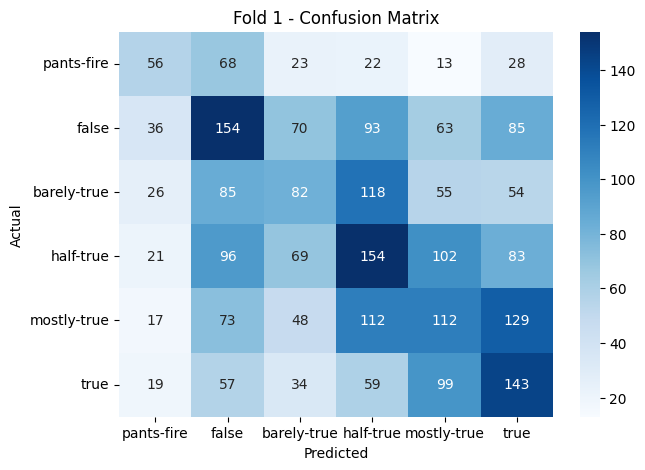


Epoch 5/10
Train Loss 0.7188 | Train Acc 0.7467
Val Acc   0.2666

Classification Report:
              precision    recall  f1-score   support

  pants-fire       0.41      0.19      0.25       210
       false       0.27      0.34      0.30       501
 barely-true       0.23      0.21      0.22       420
   half-true       0.27      0.35      0.31       525
 mostly-true       0.24      0.19      0.21       491
        true       0.28      0.27      0.27       411

    accuracy                           0.27      2558
   macro avg       0.28      0.26      0.26      2558
weighted avg       0.27      0.27      0.26      2558



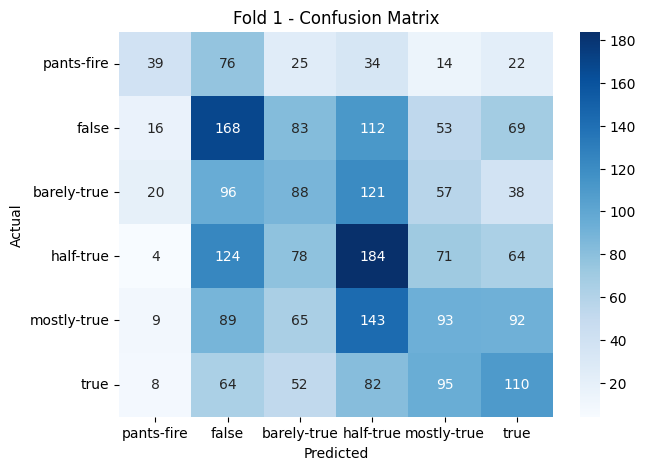


Epoch 6/10
Train Loss 0.4304 | Train Acc 0.8630
Val Acc   0.2608

Classification Report:
              precision    recall  f1-score   support

  pants-fire       0.38      0.20      0.27       210
       false       0.31      0.24      0.27       501
 barely-true       0.22      0.22      0.22       420
   half-true       0.26      0.26      0.26       525
 mostly-true       0.24      0.37      0.29       491
        true       0.27      0.23      0.25       411

    accuracy                           0.26      2558
   macro avg       0.28      0.25      0.26      2558
weighted avg       0.27      0.26      0.26      2558



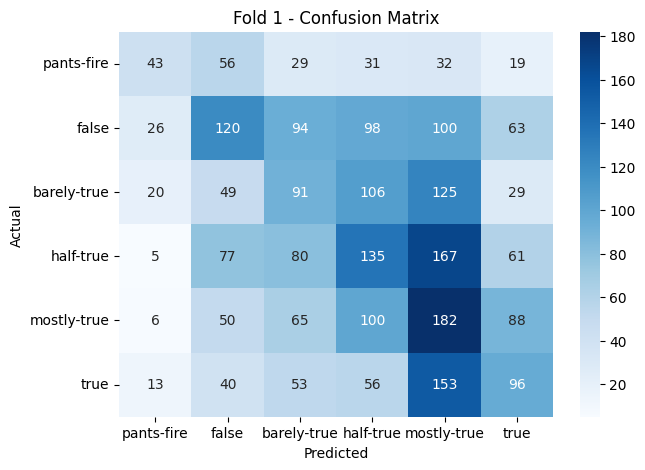


Epoch 7/10
Train Loss 0.2482 | Train Acc 0.9277
Val Acc   0.2604

Classification Report:
              precision    recall  f1-score   support

  pants-fire       0.39      0.17      0.24       210
       false       0.29      0.26      0.28       501
 barely-true       0.21      0.30      0.25       420
   half-true       0.27      0.33      0.30       525
 mostly-true       0.24      0.27      0.25       491
        true       0.34      0.16      0.22       411

    accuracy                           0.26      2558
   macro avg       0.29      0.25      0.25      2558
weighted avg       0.28      0.26      0.26      2558



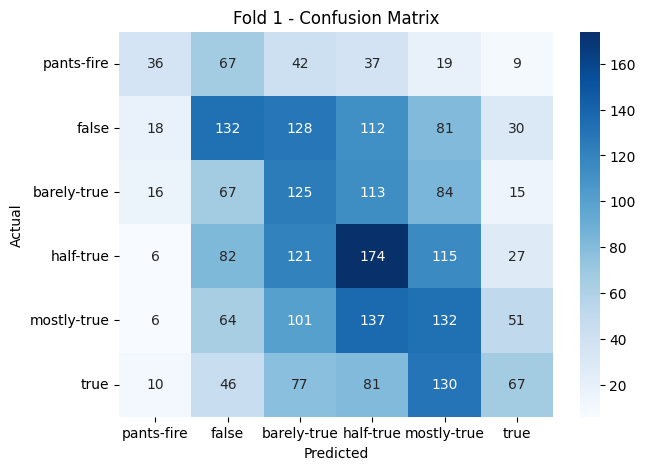


Epoch 8/10
Train Loss 0.1625 | Train Acc 0.9549
Val Acc   0.2658

Classification Report:
              precision    recall  f1-score   support

  pants-fire       0.37      0.20      0.26       210
       false       0.28      0.33      0.30       501
 barely-true       0.22      0.17      0.19       420
   half-true       0.25      0.35      0.29       525
 mostly-true       0.26      0.25      0.25       491
        true       0.28      0.23      0.26       411

    accuracy                           0.27      2558
   macro avg       0.28      0.26      0.26      2558
weighted avg       0.27      0.27      0.26      2558



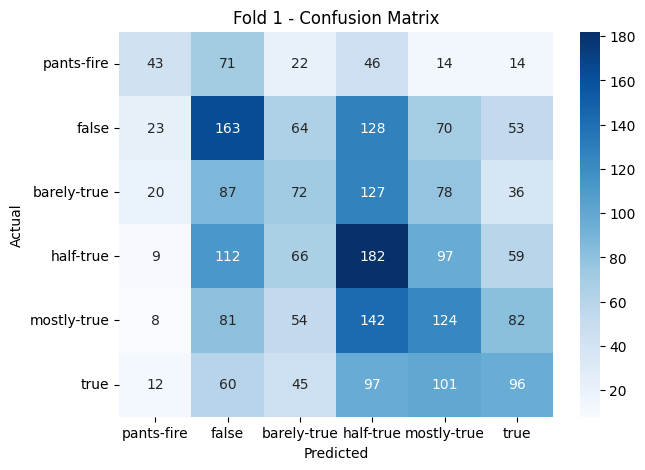


Epoch 9/10
Train Loss 0.1128 | Train Acc 0.9711
Val Acc   0.2611

Classification Report:
              precision    recall  f1-score   support

  pants-fire       0.40      0.19      0.25       210
       false       0.29      0.26      0.28       501
 barely-true       0.20      0.20      0.20       420
   half-true       0.26      0.37      0.31       525
 mostly-true       0.25      0.31      0.27       491
        true       0.28      0.16      0.21       411

    accuracy                           0.26      2558
   macro avg       0.28      0.25      0.25      2558
weighted avg       0.27      0.26      0.26      2558



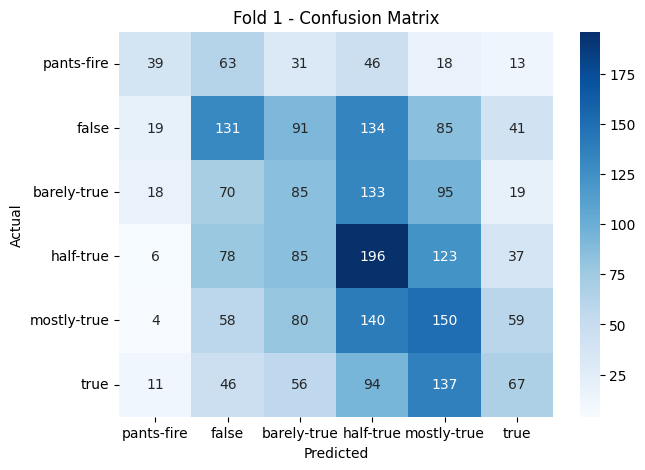


Epoch 10/10
Train Loss 0.0853 | Train Acc 0.9809
Val Acc   0.2611

Classification Report:
              precision    recall  f1-score   support

  pants-fire       0.40      0.18      0.25       210
       false       0.28      0.28      0.28       501
 barely-true       0.21      0.21      0.21       420
   half-true       0.26      0.35      0.30       525
 mostly-true       0.24      0.26      0.25       491
        true       0.28      0.21      0.24       411

    accuracy                           0.26      2558
   macro avg       0.28      0.25      0.26      2558
weighted avg       0.27      0.26      0.26      2558



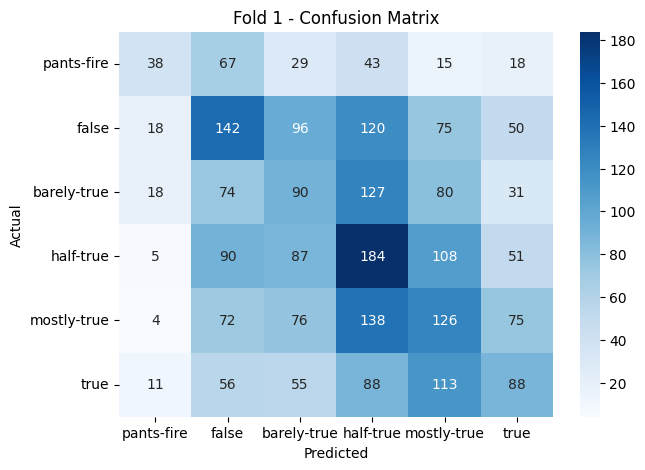


----- FOLD 2 -----

Epoch 1/10
Train Loss 1.7402 | Train Acc 0.2185
Val Acc   0.2682

Classification Report:
              precision    recall  f1-score   support

  pants-fire       0.38      0.01      0.03       209
       false       0.27      0.46      0.34       501
 barely-true       0.24      0.33      0.28       421
   half-true       0.26      0.30      0.28       525
 mostly-true       0.30      0.27      0.29       491
        true       0.35      0.05      0.09       411

    accuracy                           0.27      2558
   macro avg       0.30      0.24      0.22      2558
weighted avg       0.29      0.27      0.24      2558



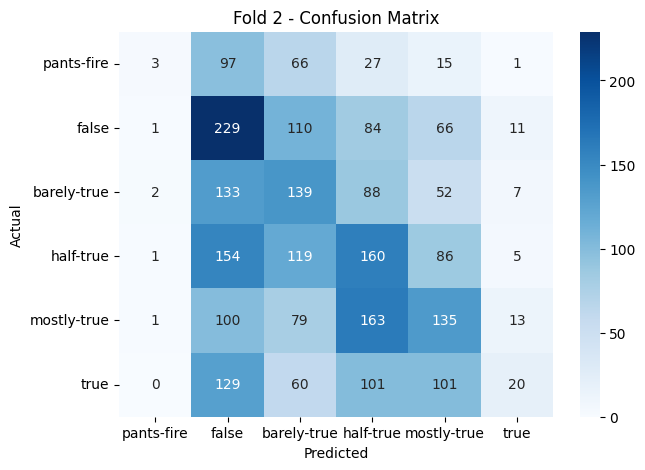


Epoch 2/10
Train Loss 1.6577 | Train Acc 0.2869
Val Acc   0.2678

Classification Report:
              precision    recall  f1-score   support

  pants-fire       0.28      0.12      0.17       209
       false       0.25      0.43      0.32       501
 barely-true       0.19      0.07      0.11       421
   half-true       0.26      0.27      0.26       525
 mostly-true       0.29      0.52      0.38       491
        true       0.39      0.04      0.07       411

    accuracy                           0.27      2558
   macro avg       0.28      0.24      0.22      2558
weighted avg       0.28      0.27      0.23      2558



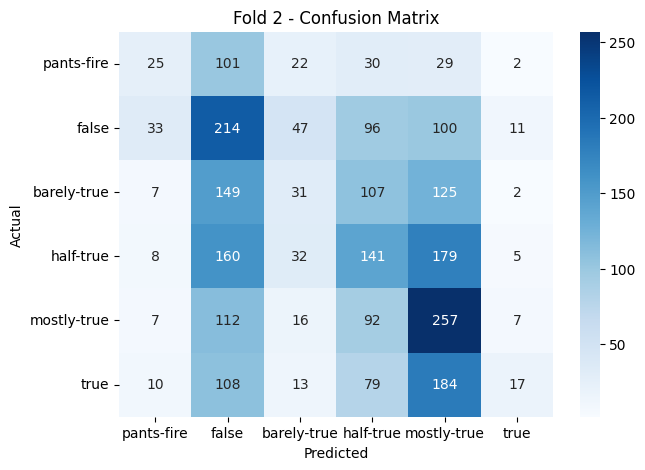


Epoch 3/10
Train Loss 1.4723 | Train Acc 0.3949
Val Acc   0.2842

Classification Report:
              precision    recall  f1-score   support

  pants-fire       0.37      0.16      0.22       209
       false       0.33      0.25      0.29       501
 barely-true       0.23      0.23      0.23       421
   half-true       0.29      0.31      0.30       525
 mostly-true       0.28      0.35      0.31       491
        true       0.28      0.33      0.30       411

    accuracy                           0.28      2558
   macro avg       0.30      0.27      0.27      2558
weighted avg       0.29      0.28      0.28      2558



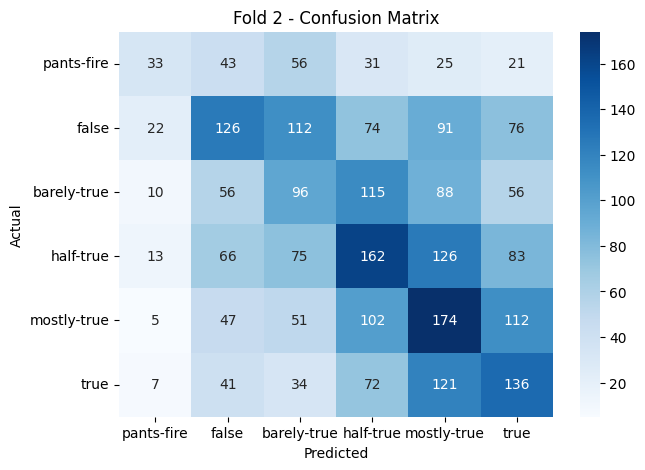


Epoch 4/10
Train Loss 1.1146 | Train Acc 0.5707
Val Acc   0.2701

Classification Report:
              precision    recall  f1-score   support

  pants-fire       0.29      0.15      0.20       209
       false       0.27      0.37      0.31       501
 barely-true       0.24      0.23      0.23       421
   half-true       0.28      0.19      0.23       525
 mostly-true       0.29      0.31      0.30       491
        true       0.26      0.31      0.28       411

    accuracy                           0.27      2558
   macro avg       0.27      0.26      0.26      2558
weighted avg       0.27      0.27      0.27      2558



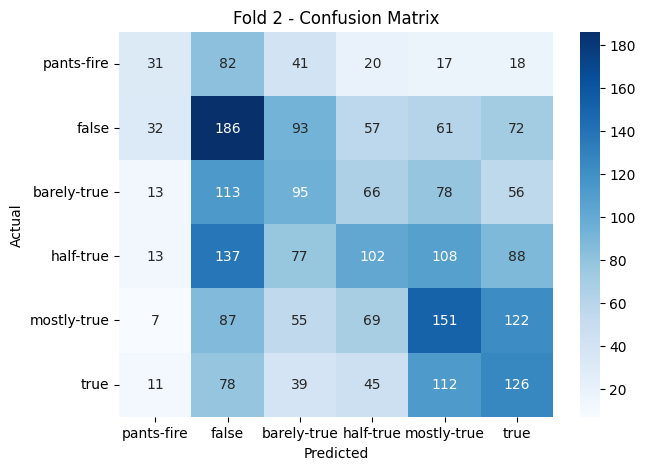


Epoch 5/10
Train Loss 0.7115 | Train Acc 0.7497
Val Acc   0.2686

Classification Report:
              precision    recall  f1-score   support

  pants-fire       0.27      0.15      0.20       209
       false       0.27      0.29      0.28       501
 barely-true       0.22      0.18      0.20       421
   half-true       0.28      0.12      0.17       525
 mostly-true       0.28      0.49      0.36       491
        true       0.28      0.32      0.30       411

    accuracy                           0.27      2558
   macro avg       0.27      0.26      0.25      2558
weighted avg       0.27      0.27      0.25      2558



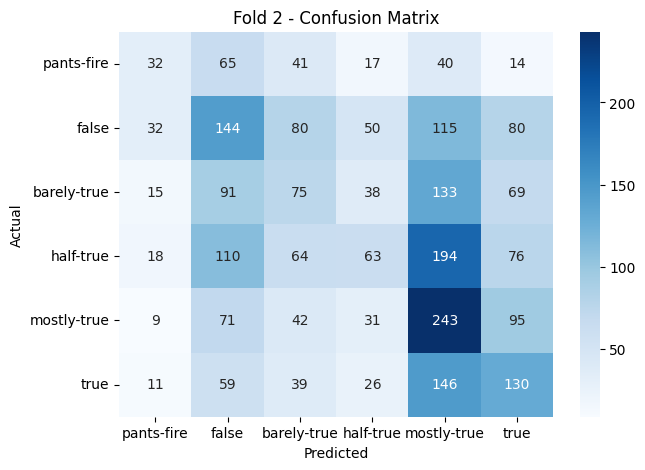


Epoch 6/10
Train Loss 0.4080 | Train Acc 0.8687
Val Acc   0.2604

Classification Report:
              precision    recall  f1-score   support

  pants-fire       0.26      0.14      0.18       209
       false       0.26      0.31      0.28       501
 barely-true       0.23      0.27      0.25       421
   half-true       0.27      0.25      0.26       525
 mostly-true       0.28      0.27      0.27       491
        true       0.26      0.26      0.26       411

    accuracy                           0.26      2558
   macro avg       0.26      0.25      0.25      2558
weighted avg       0.26      0.26      0.26      2558



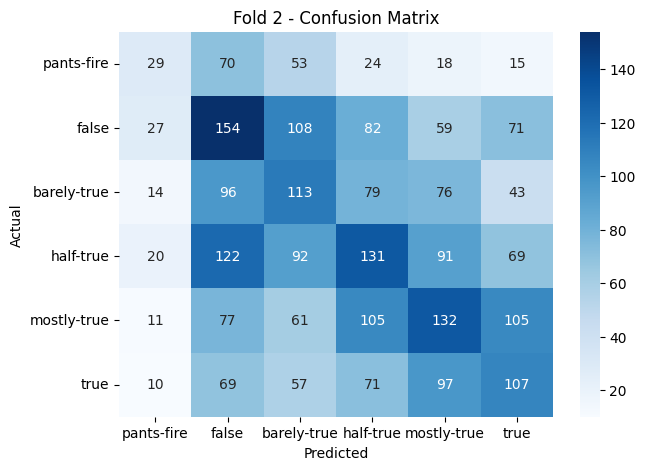


Epoch 7/10
Train Loss 0.2536 | Train Acc 0.9257
Val Acc   0.2666

Classification Report:
              precision    recall  f1-score   support

  pants-fire       0.26      0.15      0.19       209
       false       0.28      0.30      0.29       501
 barely-true       0.23      0.26      0.24       421
   half-true       0.27      0.27      0.27       525
 mostly-true       0.29      0.30      0.30       491
        true       0.26      0.24      0.25       411

    accuracy                           0.27      2558
   macro avg       0.26      0.25      0.26      2558
weighted avg       0.27      0.27      0.27      2558



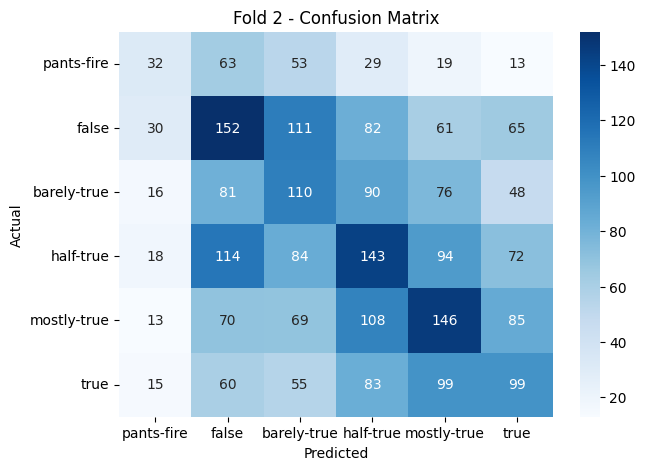


Epoch 8/10
Train Loss 0.1641 | Train Acc 0.9547
Val Acc   0.2768

Classification Report:
              precision    recall  f1-score   support

  pants-fire       0.32      0.11      0.16       209
       false       0.28      0.42      0.33       501
 barely-true       0.23      0.19      0.21       421
   half-true       0.30      0.22      0.25       525
 mostly-true       0.29      0.34      0.31       491
        true       0.28      0.27      0.28       411

    accuracy                           0.28      2558
   macro avg       0.28      0.26      0.26      2558
weighted avg       0.28      0.28      0.27      2558



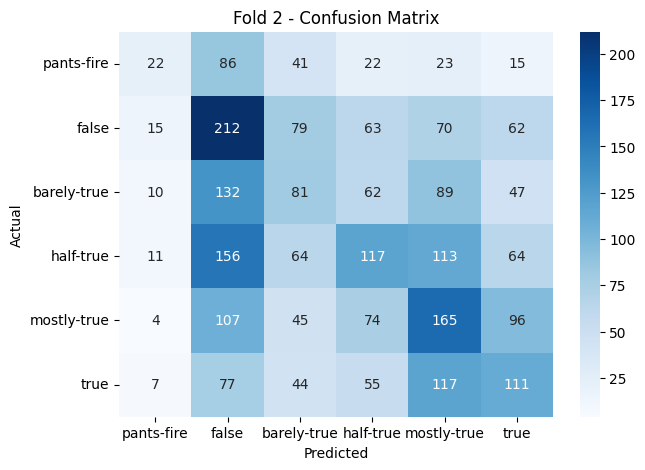


Epoch 9/10
Train Loss 0.1121 | Train Acc 0.9714
Val Acc   0.2701

Classification Report:
              precision    recall  f1-score   support

  pants-fire       0.30      0.13      0.18       209
       false       0.29      0.33      0.31       501
 barely-true       0.23      0.25      0.24       421
   half-true       0.27      0.23      0.25       525
 mostly-true       0.28      0.34      0.31       491
        true       0.27      0.26      0.26       411

    accuracy                           0.27      2558
   macro avg       0.27      0.26      0.26      2558
weighted avg       0.27      0.27      0.27      2558



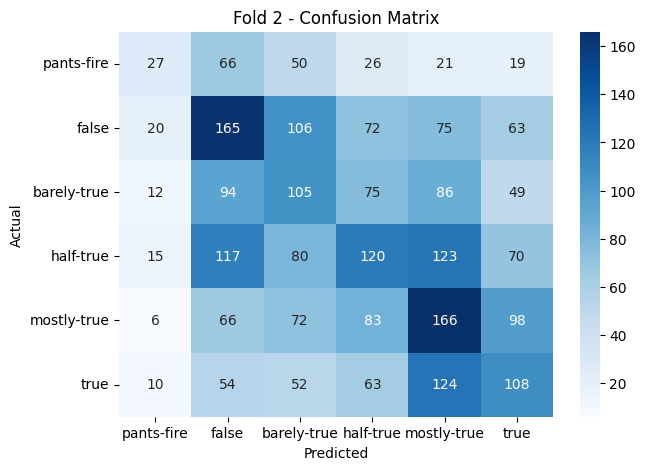


Epoch 10/10
Train Loss 0.0907 | Train Acc 0.9775
Val Acc   0.2725

Classification Report:
              precision    recall  f1-score   support

  pants-fire       0.28      0.12      0.17       209
       false       0.29      0.33      0.31       501
 barely-true       0.23      0.24      0.23       421
   half-true       0.27      0.27      0.27       525
 mostly-true       0.29      0.35      0.31       491
        true       0.27      0.23      0.25       411

    accuracy                           0.27      2558
   macro avg       0.27      0.26      0.26      2558
weighted avg       0.27      0.27      0.27      2558



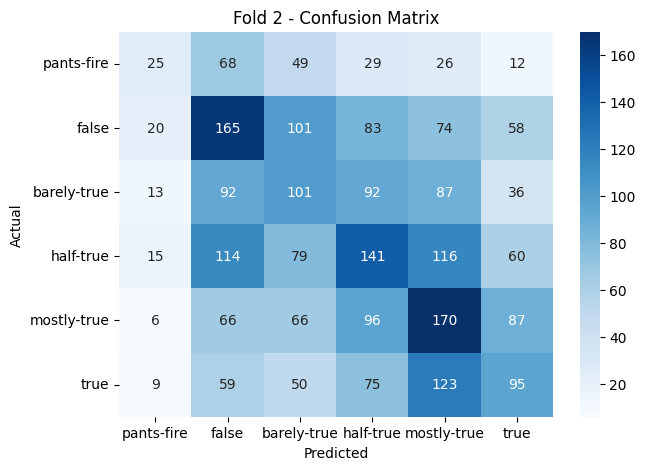


----- FOLD 3 -----

Epoch 1/10
Train Loss 1.7412 | Train Acc 0.2273
Val Acc   0.2616

Classification Report:
              precision    recall  f1-score   support

  pants-fire       0.00      0.00      0.00       209
       false       0.25      0.47      0.32       500
 barely-true       0.22      0.22      0.22       421
   half-true       0.26      0.25      0.25       526
 mostly-true       0.31      0.35      0.33       490
        true       0.27      0.10      0.15       411

    accuracy                           0.26      2557
   macro avg       0.22      0.23      0.21      2557
weighted avg       0.24      0.26      0.24      2557



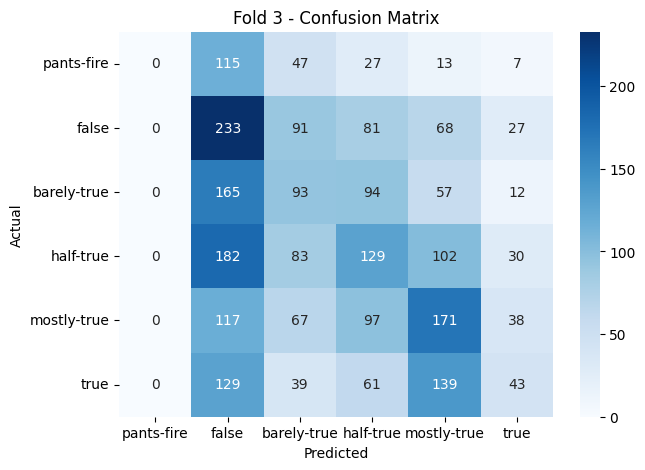


Epoch 2/10
Train Loss 1.6603 | Train Acc 0.2837
Val Acc   0.2589

Classification Report:
              precision    recall  f1-score   support

  pants-fire       0.32      0.09      0.14       209
       false       0.26      0.47      0.34       500
 barely-true       0.24      0.09      0.13       421
   half-true       0.28      0.21      0.24       526
 mostly-true       0.26      0.08      0.12       490
        true       0.24      0.54      0.34       411

    accuracy                           0.26      2557
   macro avg       0.27      0.25      0.22      2557
weighted avg       0.26      0.26      0.23      2557



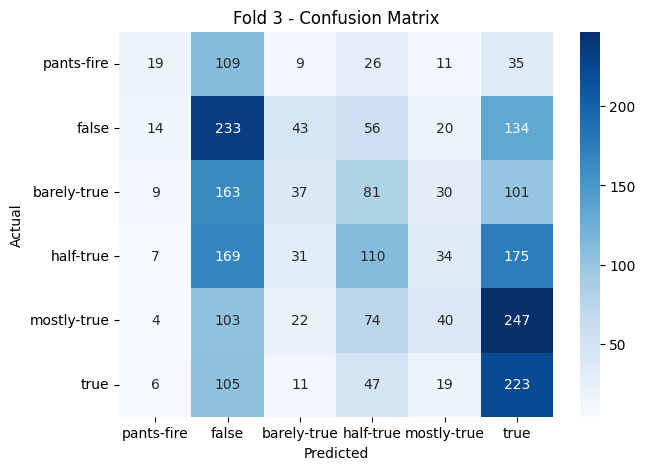


Epoch 3/10
Train Loss 1.4833 | Train Acc 0.3946
Val Acc   0.2710

Classification Report:
              precision    recall  f1-score   support

  pants-fire       0.27      0.34      0.30       209
       false       0.33      0.20      0.24       500
 barely-true       0.23      0.34      0.27       421
   half-true       0.28      0.18      0.22       526
 mostly-true       0.28      0.38      0.32       490
        true       0.28      0.23      0.25       411

    accuracy                           0.27      2557
   macro avg       0.28      0.28      0.27      2557
weighted avg       0.28      0.27      0.27      2557



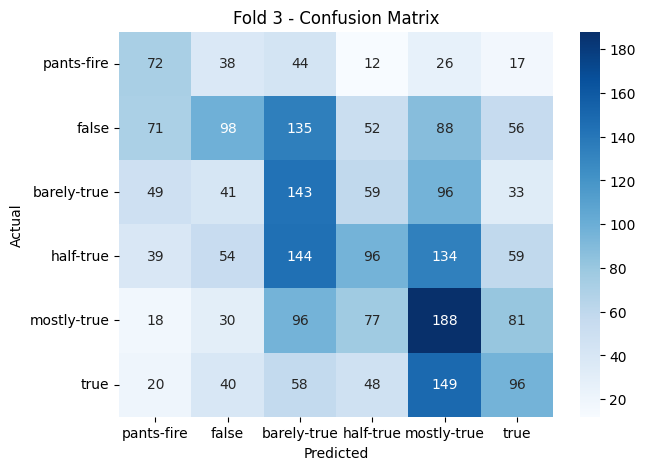


Epoch 4/10
Train Loss 1.1251 | Train Acc 0.5712
Val Acc   0.2773

Classification Report:
              precision    recall  f1-score   support

  pants-fire       0.33      0.24      0.28       209
       false       0.34      0.27      0.30       500
 barely-true       0.25      0.18      0.21       421
   half-true       0.24      0.47      0.32       526
 mostly-true       0.29      0.21      0.25       490
        true       0.28      0.24      0.26       411

    accuracy                           0.28      2557
   macro avg       0.29      0.27      0.27      2557
weighted avg       0.29      0.28      0.27      2557



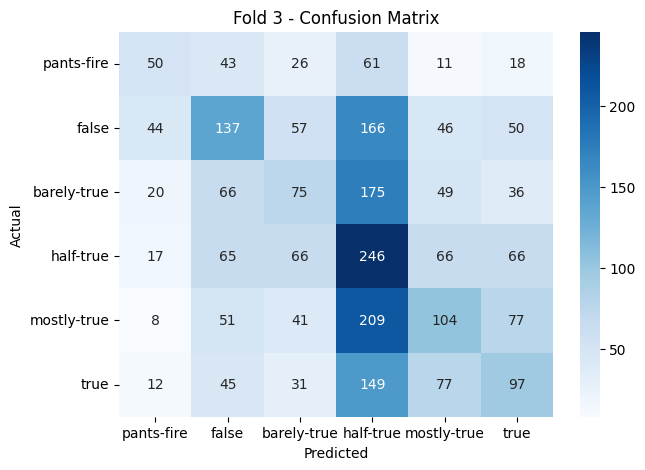


Epoch 5/10
Train Loss 0.7095 | Train Acc 0.7503
Val Acc   0.2632

Classification Report:
              precision    recall  f1-score   support

  pants-fire       0.38      0.17      0.23       209
       false       0.27      0.37      0.32       500
 barely-true       0.22      0.22      0.22       421
   half-true       0.26      0.27      0.27       526
 mostly-true       0.26      0.27      0.27       490
        true       0.27      0.20      0.23       411

    accuracy                           0.26      2557
   macro avg       0.28      0.25      0.26      2557
weighted avg       0.27      0.26      0.26      2557



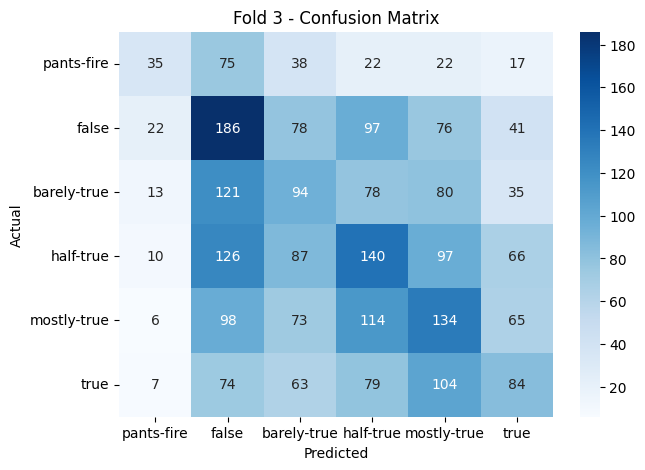


Epoch 6/10
Train Loss 0.3970 | Train Acc 0.8760
Val Acc   0.2683

Classification Report:
              precision    recall  f1-score   support

  pants-fire       0.44      0.17      0.24       209
       false       0.30      0.29      0.30       500
 barely-true       0.24      0.23      0.24       421
   half-true       0.24      0.36      0.29       526
 mostly-true       0.26      0.28      0.27       490
        true       0.31      0.20      0.24       411

    accuracy                           0.27      2557
   macro avg       0.30      0.25      0.26      2557
weighted avg       0.28      0.27      0.27      2557



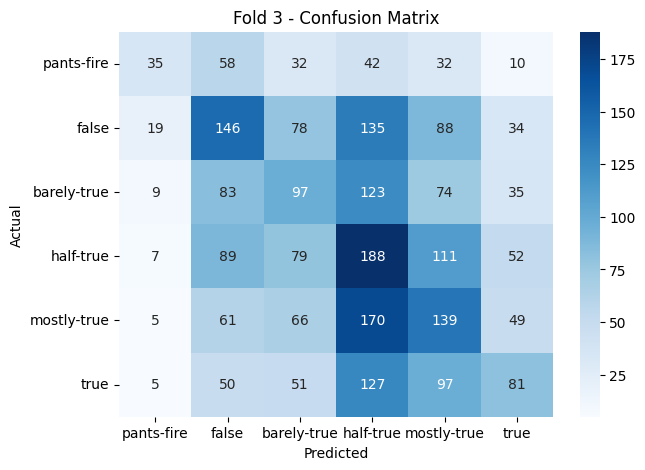


Epoch 7/10
Train Loss 0.2328 | Train Acc 0.9333
Val Acc   0.2695

Classification Report:
              precision    recall  f1-score   support

  pants-fire       0.46      0.15      0.23       209
       false       0.29      0.33      0.31       500
 barely-true       0.24      0.20      0.22       421
   half-true       0.24      0.33      0.28       526
 mostly-true       0.26      0.27      0.27       490
        true       0.28      0.25      0.27       411

    accuracy                           0.27      2557
   macro avg       0.30      0.26      0.26      2557
weighted avg       0.28      0.27      0.27      2557



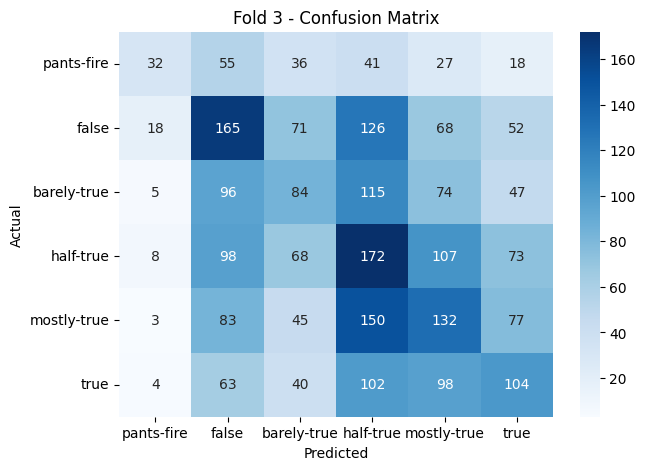


Epoch 8/10
Train Loss 0.1557 | Train Acc 0.9584
Val Acc   0.2659

Classification Report:
              precision    recall  f1-score   support

  pants-fire       0.34      0.21      0.26       209
       false       0.28      0.31      0.29       500
 barely-true       0.22      0.21      0.22       421
   half-true       0.26      0.36      0.30       526
 mostly-true       0.27      0.24      0.25       490
        true       0.29      0.21      0.24       411

    accuracy                           0.27      2557
   macro avg       0.28      0.26      0.26      2557
weighted avg       0.27      0.27      0.26      2557



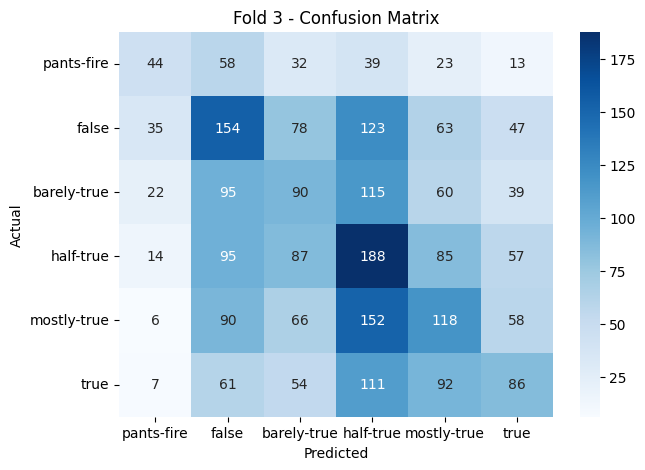


Epoch 9/10
Train Loss 0.1052 | Train Acc 0.9733
Val Acc   0.2636

Classification Report:
              precision    recall  f1-score   support

  pants-fire       0.34      0.16      0.21       209
       false       0.28      0.31      0.30       500
 barely-true       0.22      0.22      0.22       421
   half-true       0.25      0.34      0.29       526
 mostly-true       0.27      0.24      0.25       490
        true       0.28      0.23      0.26       411

    accuracy                           0.26      2557
   macro avg       0.27      0.25      0.26      2557
weighted avg       0.27      0.26      0.26      2557



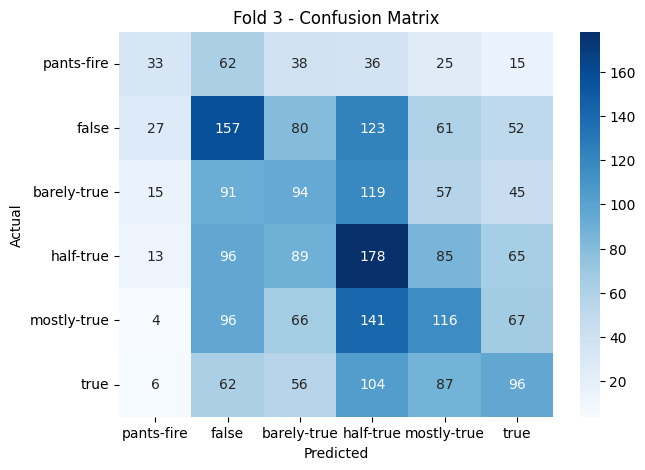


Epoch 10/10
Train Loss 0.0834 | Train Acc 0.9814
Val Acc   0.2734

Classification Report:
              precision    recall  f1-score   support

  pants-fire       0.37      0.16      0.23       209
       false       0.29      0.31      0.30       500
 barely-true       0.25      0.21      0.23       421
   half-true       0.26      0.34      0.30       526
 mostly-true       0.26      0.31      0.29       490
        true       0.29      0.22      0.25       411

    accuracy                           0.27      2557
   macro avg       0.29      0.26      0.26      2557
weighted avg       0.28      0.27      0.27      2557



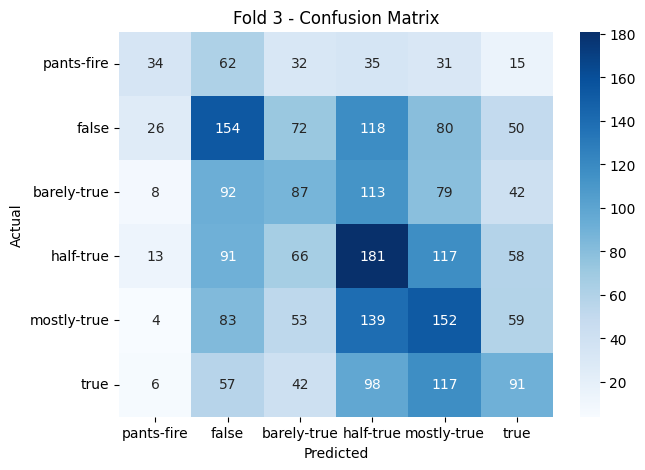


----- FOLD 4 -----

Epoch 1/10
Train Loss 1.7419 | Train Acc 0.2179
Val Acc   0.2640

Classification Report:
              precision    recall  f1-score   support

  pants-fire       1.00      0.00      0.01       209
       false       0.28      0.28      0.28       501
 barely-true       0.22      0.24      0.23       420
   half-true       0.26      0.26      0.26       526
 mostly-true       0.27      0.51      0.35       491
        true       0.33      0.11      0.16       410

    accuracy                           0.26      2557
   macro avg       0.39      0.23      0.22      2557
weighted avg       0.33      0.26      0.24      2557



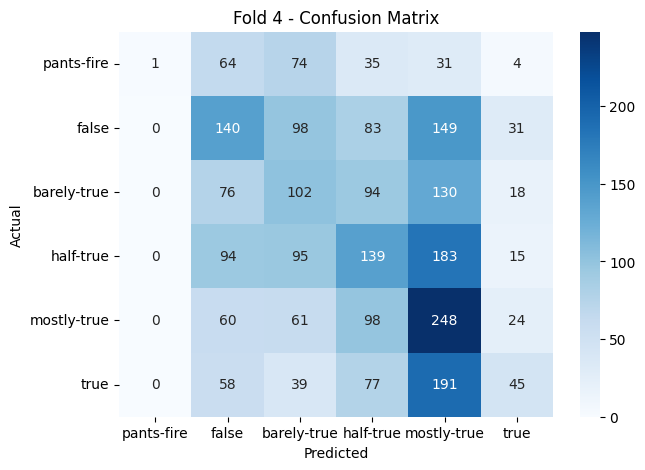


Epoch 2/10
Train Loss 1.6559 | Train Acc 0.2894
Val Acc   0.2562

Classification Report:
              precision    recall  f1-score   support

  pants-fire       0.40      0.17      0.24       209
       false       0.26      0.59      0.36       501
 barely-true       0.22      0.01      0.03       420
   half-true       0.28      0.15      0.19       526
 mostly-true       0.24      0.08      0.12       491
        true       0.23      0.49      0.31       410

    accuracy                           0.26      2557
   macro avg       0.27      0.25      0.21      2557
weighted avg       0.26      0.26      0.21      2557



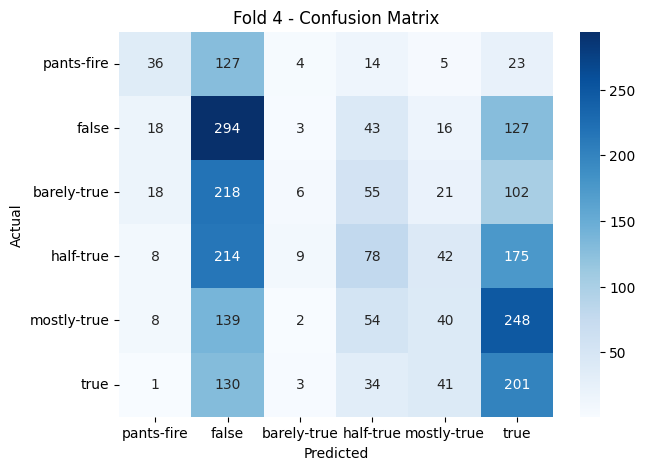


Epoch 3/10
Train Loss 1.4588 | Train Acc 0.4049
Val Acc   0.2698

Classification Report:
              precision    recall  f1-score   support

  pants-fire       0.37      0.18      0.24       209
       false       0.31      0.29      0.30       501
 barely-true       0.27      0.18      0.22       420
   half-true       0.26      0.33      0.29       526
 mostly-true       0.27      0.10      0.15       491
        true       0.25      0.50      0.33       410

    accuracy                           0.27      2557
   macro avg       0.29      0.26      0.25      2557
weighted avg       0.28      0.27      0.25      2557



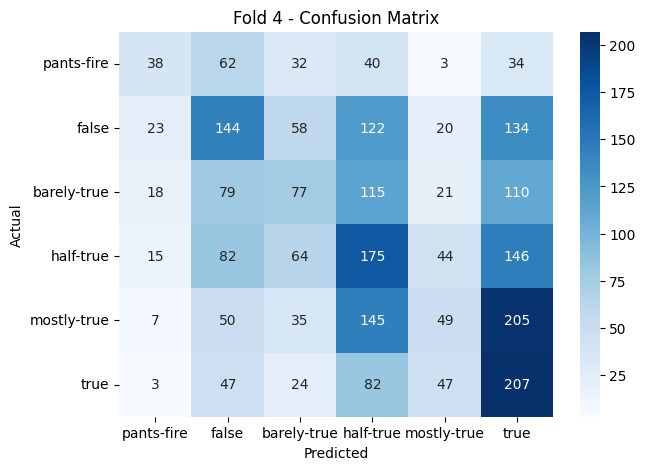


Epoch 4/10
Train Loss 1.0836 | Train Acc 0.5905
Val Acc   0.2753

Classification Report:
              precision    recall  f1-score   support

  pants-fire       0.31      0.26      0.29       209
       false       0.29      0.39      0.33       501
 barely-true       0.29      0.08      0.13       420
   half-true       0.27      0.30      0.29       526
 mostly-true       0.26      0.26      0.26       491
        true       0.26      0.33      0.29       410

    accuracy                           0.28      2557
   macro avg       0.28      0.27      0.26      2557
weighted avg       0.28      0.28      0.26      2557



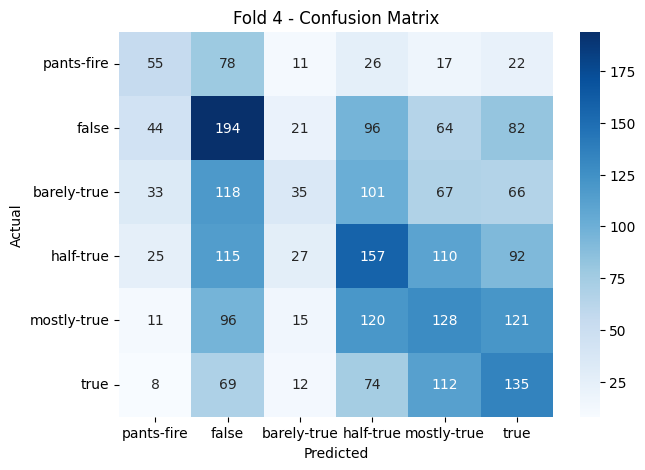


Epoch 5/10
Train Loss 0.6814 | Train Acc 0.7634
Val Acc   0.2730

Classification Report:
              precision    recall  f1-score   support

  pants-fire       0.35      0.14      0.20       209
       false       0.27      0.27      0.27       501
 barely-true       0.26      0.20      0.23       420
   half-true       0.26      0.42      0.32       526
 mostly-true       0.29      0.26      0.27       491
        true       0.29      0.25      0.26       410

    accuracy                           0.27      2557
   macro avg       0.29      0.26      0.26      2557
weighted avg       0.28      0.27      0.27      2557



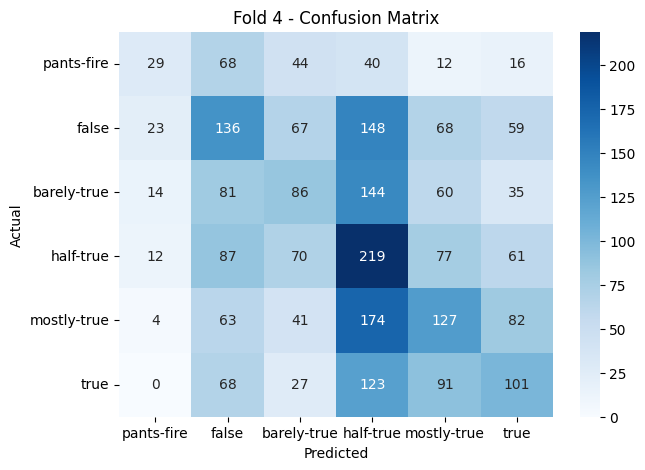


Epoch 6/10
Train Loss 0.3953 | Train Acc 0.8760
Val Acc   0.2691

Classification Report:
              precision    recall  f1-score   support

  pants-fire       0.32      0.16      0.22       209
       false       0.26      0.38      0.31       501
 barely-true       0.27      0.15      0.20       420
   half-true       0.26      0.31      0.28       526
 mostly-true       0.27      0.22      0.24       491
        true       0.28      0.32      0.30       410

    accuracy                           0.27      2557
   macro avg       0.28      0.26      0.26      2557
weighted avg       0.27      0.27      0.26      2557



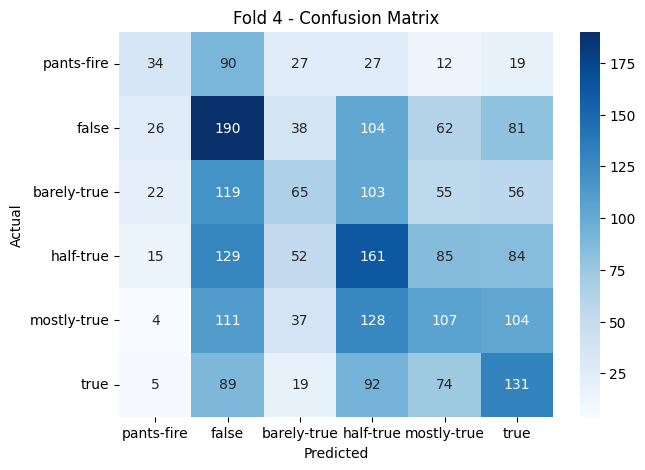


Epoch 7/10
Train Loss 0.2332 | Train Acc 0.9298
Val Acc   0.2710

Classification Report:
              precision    recall  f1-score   support

  pants-fire       0.35      0.14      0.20       209
       false       0.28      0.32      0.29       501
 barely-true       0.28      0.19      0.23       420
   half-true       0.25      0.32      0.28       526
 mostly-true       0.26      0.28      0.27       491
        true       0.29      0.29      0.29       410

    accuracy                           0.27      2557
   macro avg       0.28      0.26      0.26      2557
weighted avg       0.28      0.27      0.27      2557



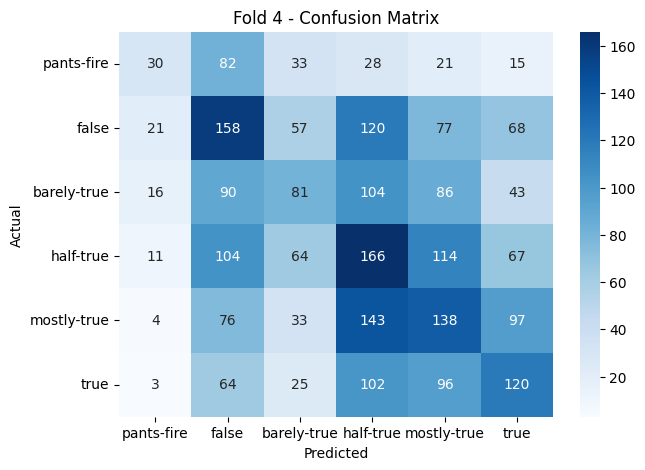


Epoch 8/10
Train Loss 0.1526 | Train Acc 0.9599
Val Acc   0.2663

Classification Report:
              precision    recall  f1-score   support

  pants-fire       0.36      0.16      0.22       209
       false       0.30      0.25      0.28       501
 barely-true       0.26      0.25      0.26       420
   half-true       0.24      0.32      0.28       526
 mostly-true       0.25      0.32      0.28       491
        true       0.28      0.21      0.24       410

    accuracy                           0.27      2557
   macro avg       0.28      0.25      0.26      2557
weighted avg       0.28      0.27      0.26      2557



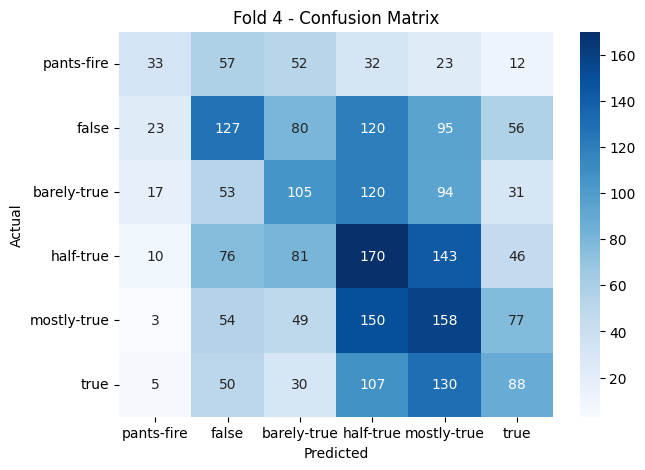


Epoch 9/10
Train Loss 0.1103 | Train Acc 0.9717
Val Acc   0.2702

Classification Report:
              precision    recall  f1-score   support

  pants-fire       0.36      0.16      0.22       209
       false       0.30      0.29      0.30       501
 barely-true       0.27      0.24      0.26       420
   half-true       0.24      0.32      0.28       526
 mostly-true       0.26      0.31      0.28       491
        true       0.27      0.23      0.25       410

    accuracy                           0.27      2557
   macro avg       0.29      0.26      0.26      2557
weighted avg       0.28      0.27      0.27      2557



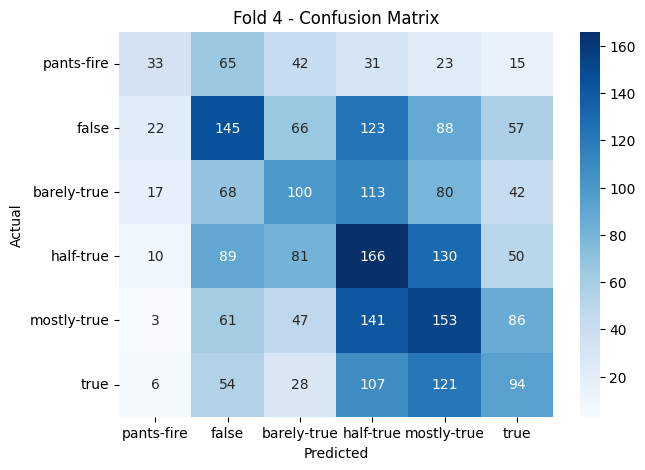


Epoch 10/10
Train Loss 0.0814 | Train Acc 0.9799
Val Acc   0.2706

Classification Report:
              precision    recall  f1-score   support

  pants-fire       0.36      0.15      0.22       209
       false       0.30      0.28      0.29       501
 barely-true       0.27      0.26      0.26       420
   half-true       0.25      0.31      0.28       526
 mostly-true       0.26      0.30      0.28       491
        true       0.28      0.25      0.26       410

    accuracy                           0.27      2557
   macro avg       0.29      0.26      0.26      2557
weighted avg       0.28      0.27      0.27      2557



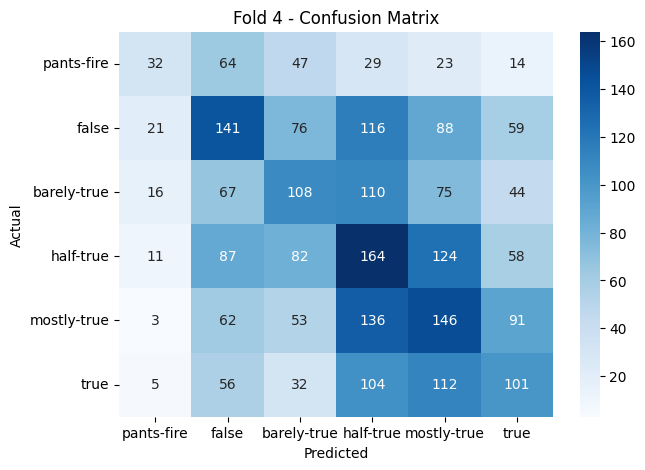


----- FOLD 5 -----

Epoch 1/10
Train Loss 1.7459 | Train Acc 0.2159
Val Acc   0.2382

Classification Report:
              precision    recall  f1-score   support

  pants-fire       0.60      0.01      0.03       210
       false       0.28      0.24      0.26       501
 barely-true       0.20      0.57      0.30       420
   half-true       0.26      0.02      0.04       525
 mostly-true       0.26      0.45      0.33       491
        true       0.28      0.02      0.04       410

    accuracy                           0.24      2557
   macro avg       0.31      0.22      0.17      2557
weighted avg       0.29      0.24      0.18      2557



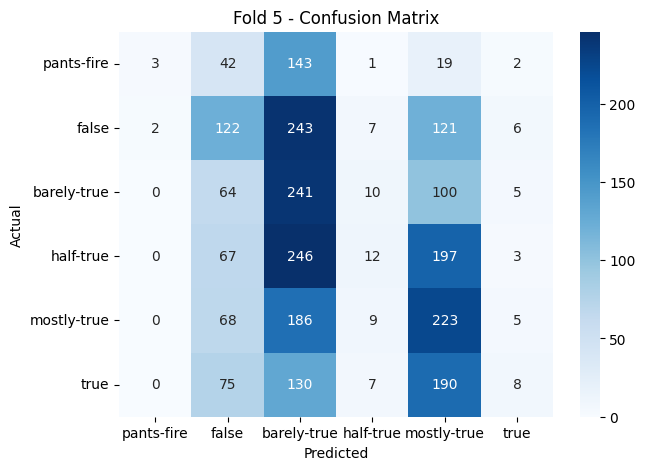


Epoch 2/10
Train Loss 1.6643 | Train Acc 0.2795
Val Acc   0.2749

Classification Report:
              precision    recall  f1-score   support

  pants-fire       0.32      0.18      0.23       210
       false       0.28      0.25      0.27       501
 barely-true       0.29      0.12      0.17       420
   half-true       0.25      0.50      0.34       525
 mostly-true       0.29      0.35      0.32       491
        true       0.27      0.13      0.18       410

    accuracy                           0.27      2557
   macro avg       0.29      0.26      0.25      2557
weighted avg       0.28      0.27      0.26      2557



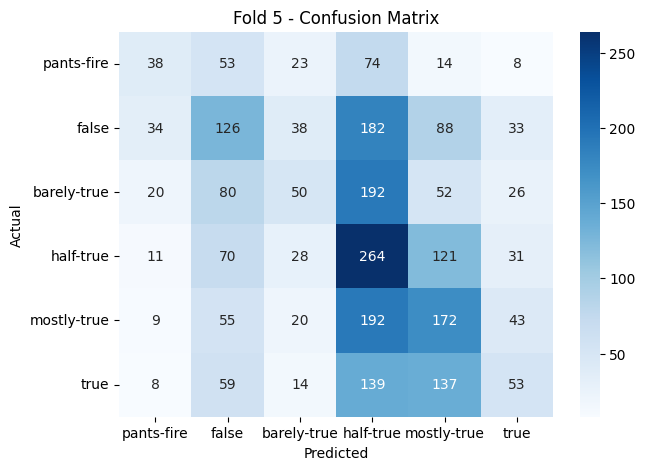


Epoch 3/10
Train Loss 1.4917 | Train Acc 0.3831
Val Acc   0.2781

Classification Report:
              precision    recall  f1-score   support

  pants-fire       0.30      0.22      0.25       210
       false       0.25      0.40      0.31       501
 barely-true       0.26      0.17      0.21       420
   half-true       0.36      0.17      0.23       525
 mostly-true       0.29      0.33      0.31       491
        true       0.26      0.35      0.30       410

    accuracy                           0.28      2557
   macro avg       0.29      0.27      0.27      2557
weighted avg       0.29      0.28      0.27      2557



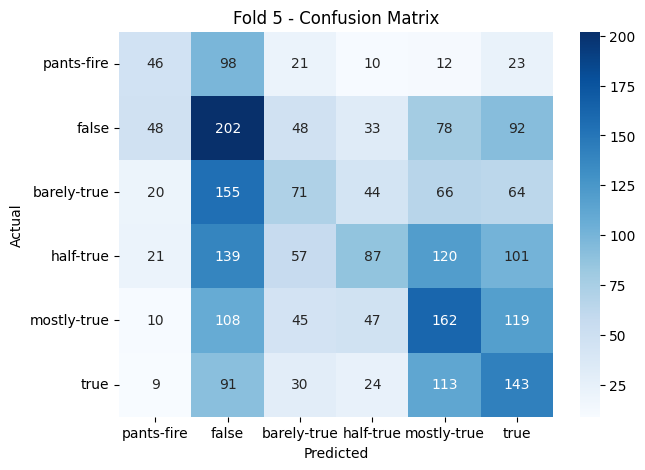


Epoch 4/10
Train Loss 1.1545 | Train Acc 0.5614
Val Acc   0.2871

Classification Report:
              precision    recall  f1-score   support

  pants-fire       0.40      0.19      0.25       210
       false       0.30      0.31      0.30       501
 barely-true       0.29      0.29      0.29       420
   half-true       0.31      0.23      0.26       525
 mostly-true       0.25      0.40      0.31       491
        true       0.29      0.25      0.27       410

    accuracy                           0.29      2557
   macro avg       0.31      0.28      0.28      2557
weighted avg       0.30      0.29      0.28      2557



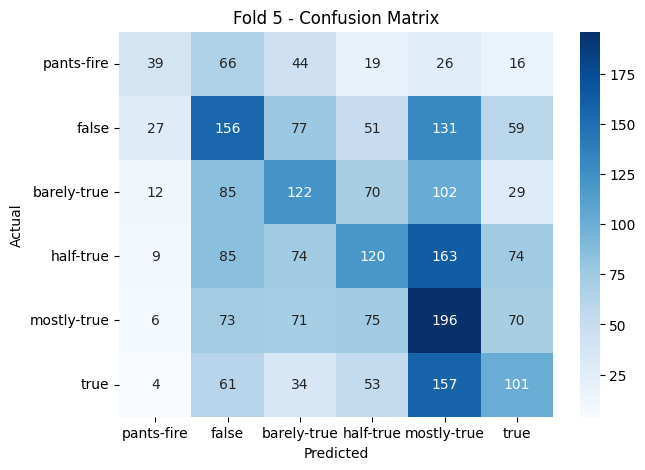


Epoch 5/10
Train Loss 0.7461 | Train Acc 0.7394
Val Acc   0.2624

Classification Report:
              precision    recall  f1-score   support

  pants-fire       0.33      0.10      0.16       210
       false       0.26      0.38      0.31       501
 barely-true       0.25      0.23      0.24       420
   half-true       0.31      0.22      0.26       525
 mostly-true       0.26      0.35      0.30       491
        true       0.22      0.18      0.19       410

    accuracy                           0.26      2557
   macro avg       0.27      0.24      0.24      2557
weighted avg       0.27      0.26      0.25      2557



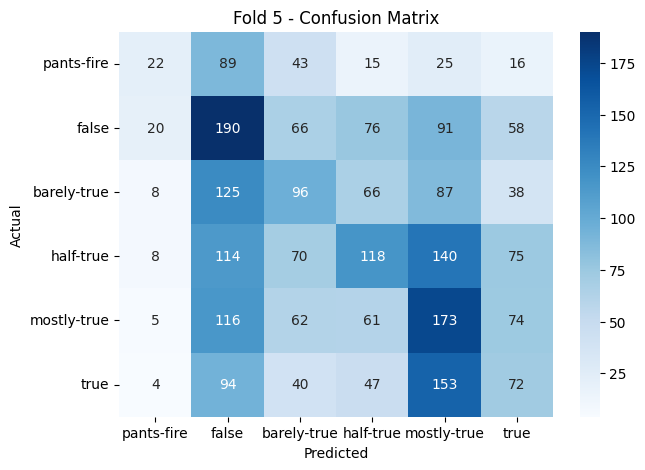


Epoch 6/10
Train Loss 0.4483 | Train Acc 0.8536
Val Acc   0.2687

Classification Report:
              precision    recall  f1-score   support

  pants-fire       0.31      0.20      0.24       210
       false       0.30      0.26      0.28       501
 barely-true       0.24      0.27      0.26       420
   half-true       0.27      0.36      0.31       525
 mostly-true       0.25      0.27      0.26       491
        true       0.27      0.20      0.23       410

    accuracy                           0.27      2557
   macro avg       0.27      0.26      0.26      2557
weighted avg       0.27      0.27      0.27      2557



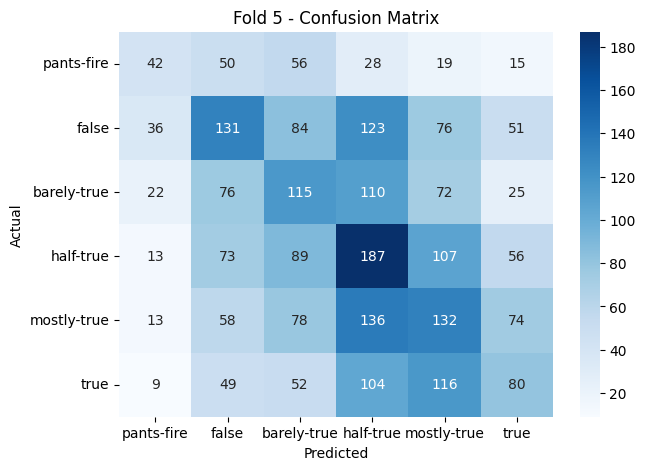


Epoch 7/10
Train Loss 0.2665 | Train Acc 0.9214
Val Acc   0.2648

Classification Report:
              precision    recall  f1-score   support

  pants-fire       0.30      0.12      0.17       210
       false       0.28      0.30      0.29       501
 barely-true       0.24      0.24      0.24       420
   half-true       0.27      0.27      0.27       525
 mostly-true       0.27      0.34      0.30       491
        true       0.26      0.22      0.23       410

    accuracy                           0.26      2557
   macro avg       0.27      0.25      0.25      2557
weighted avg       0.27      0.26      0.26      2557



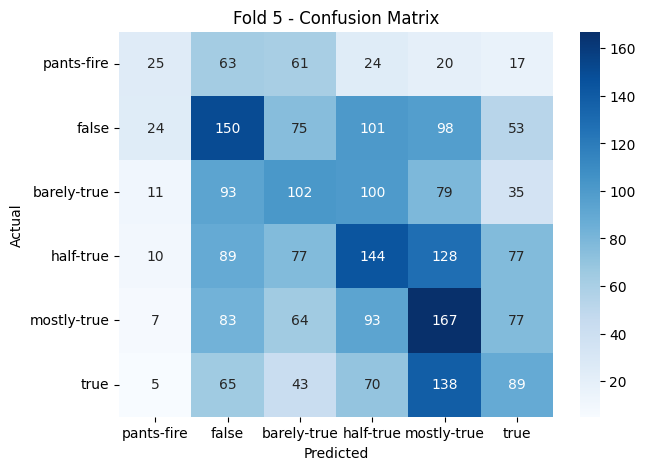


Epoch 8/10
Train Loss 0.1755 | Train Acc 0.9491
Val Acc   0.2687

Classification Report:
              precision    recall  f1-score   support

  pants-fire       0.31      0.18      0.22       210
       false       0.27      0.23      0.25       501
 barely-true       0.26      0.27      0.26       420
   half-true       0.28      0.33      0.30       525
 mostly-true       0.26      0.32      0.28       491
        true       0.27      0.23      0.25       410

    accuracy                           0.27      2557
   macro avg       0.27      0.26      0.26      2557
weighted avg       0.27      0.27      0.27      2557



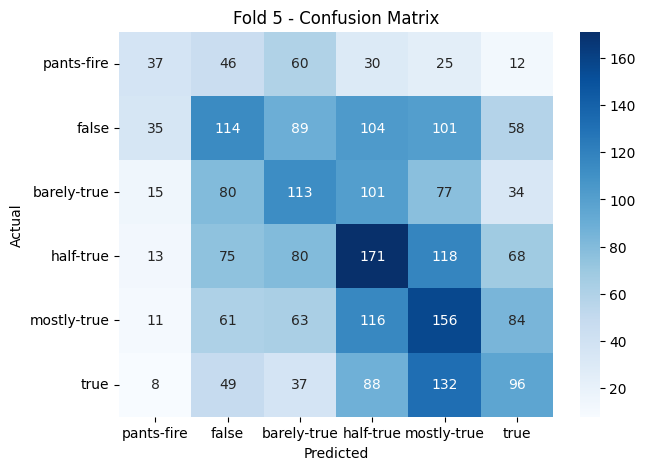


Epoch 9/10
Train Loss 0.1191 | Train Acc 0.9685
Val Acc   0.2624

Classification Report:
              precision    recall  f1-score   support

  pants-fire       0.30      0.15      0.20       210
       false       0.26      0.27      0.27       501
 barely-true       0.26      0.26      0.26       420
   half-true       0.28      0.31      0.29       525
 mostly-true       0.24      0.30      0.27       491
        true       0.26      0.22      0.24       410

    accuracy                           0.26      2557
   macro avg       0.27      0.25      0.25      2557
weighted avg       0.26      0.26      0.26      2557



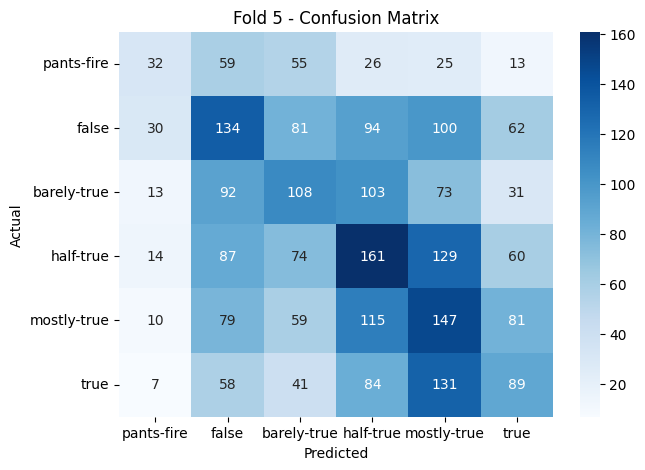


Epoch 10/10
Train Loss 0.0909 | Train Acc 0.9773
Val Acc   0.2659

Classification Report:
              precision    recall  f1-score   support

  pants-fire       0.30      0.15      0.20       210
       false       0.27      0.30      0.28       501
 barely-true       0.26      0.26      0.26       420
   half-true       0.27      0.28      0.28       525
 mostly-true       0.25      0.30      0.27       491
        true       0.28      0.22      0.25       410

    accuracy                           0.27      2557
   macro avg       0.27      0.25      0.26      2557
weighted avg       0.27      0.27      0.26      2557



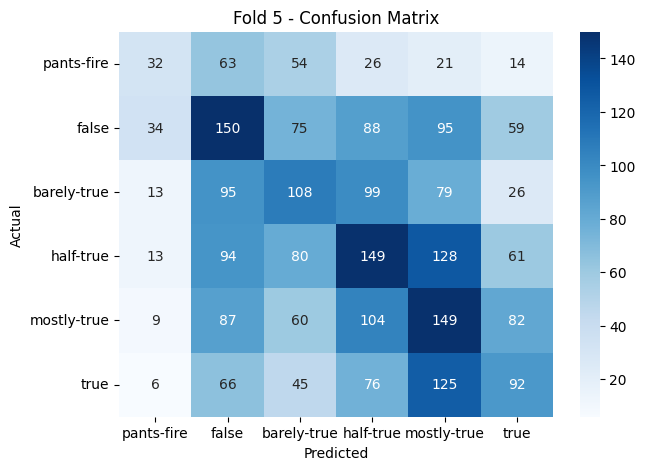


Cross-validation accuracies: [0.2611415168100078, 0.27247849882720876, 0.2733672272193977, 0.2706296441141963, 0.26593664450527965]
Mean accuracy: 0.26871070629521804


In [ ]:

skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
fold_accuracies = []

for fold, (train_idx, val_idx) in enumerate(skf.split(DF, DF['label']), 1):
    print(f"\n----- FOLD {fold} -----")

    # Use DF everywhere
    train_df = DF.iloc[train_idx].reset_index(drop=True)
    val_df   = DF.iloc[val_idx].reset_index(drop=True)

    train_data = LIARDataset(train_df['statement'], train_df['label'], tokenizer, MAX_LEN)
    val_data   = LIARDataset(val_df['statement'], val_df['label'], tokenizer, MAX_LEN)

    train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    val_loader   = DataLoader(val_data, batch_size=BATCH_SIZE)

    model = BertBiLSTMAttn(MODEL_NAME).to(device)
    optimizer = AdamW(model.parameters(), lr=LR)

    total_steps = len(train_loader) * EPOCHS
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=int(0.1 * total_steps),
        num_training_steps=total_steps
    )

    for epoch in range(1, EPOCHS + 1):
        print(f"\nEpoch {epoch}/{EPOCHS}")

        train_loss, train_acc = train_epoch(model, train_loader, optimizer, scheduler)
        val_acc, y_true, y_pred = eval_model(model, val_loader)

        all_train_acc.append(train_acc)
        all_val_acc.append(val_acc)
        all_train_loss.append(train_loss)
        all_val_loss.append(1 - val_acc)  # placeholder val_loss

        print(f"Train Loss {train_loss:.4f} | Train Acc {train_acc:.4f}")
        print(f"Val Acc   {val_acc:.4f}")

        # CLASS-WISE METRICS
        print("\nClassification Report:")
        print(classification_report(
            y_true,
            y_pred,
            target_names=["pants-fire","false","barely-true","half-true","mostly-true","true"]
        ))

        # CONFUSION MATRIX
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(7,5))
        sns.heatmap(
            cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["pants-fire","false","barely-true","half-true","mostly-true","true"],
            yticklabels=["pants-fire","false","barely-true","half-true","mostly-true","true"]
        )
        plt.title(f"Fold {fold} - Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()

    fold_accuracies.append(val_acc)

print("\nCross-validation accuracies:", fold_accuracies)
print("Mean accuracy:", np.mean(fold_accuracies))

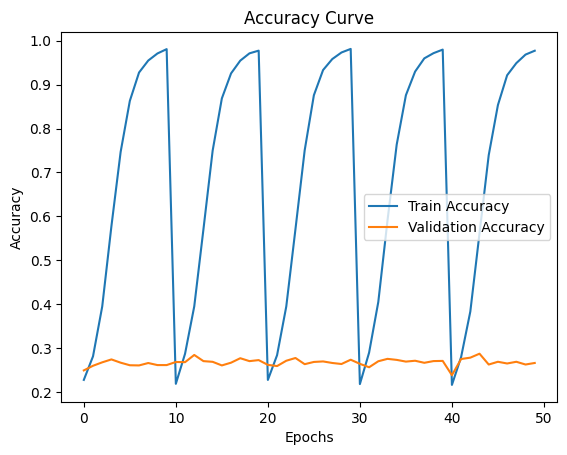

Text(0, 0.5, 'Loss')

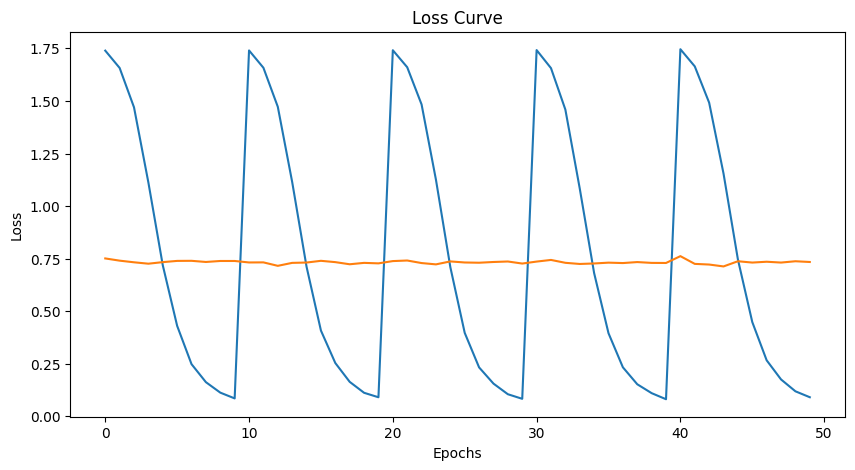

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(all_train_acc, label="Train Accuracy")
plt.plot(all_val_acc, label="Validation Accuracy")
plt.title("Accuracy Curve")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(all_train_loss, label="Train Loss")
plt.plot(all_val_loss, label="Validation Loss")
plt.title("Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
